<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Pivot Tables](03.09-Pivot-Tables.ipynb) | [Contents](Index.ipynb) | [Working with Time Series](03.11-Working-with-Time-Series.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.10-Working-With-Strings.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Vectorized String Operations

One strength of Python is its relative ease in handling and manipulating string data.
Pandas builds on this and provides a comprehensive set of *vectorized string operations* that become an essential piece of the type of munging required when working with (read: cleaning up) real-world data.
In this section, we'll walk through some of the Pandas string operations, and then take a look at using them to partially clean up a very messy dataset of recipes collected from the Internet.

## Introducing Pandas String Operations

We saw in previous sections how tools like NumPy and Pandas generalize arithmetic operations so that we can easily and quickly perform the same operation on many array elements. For example:

In [1]:
import numpy as np
x = np.array([2, 3, 5, 7, 11, 13])
x * 2

array([ 4,  6, 10, 14, 22, 26])

This *vectorization* of operations simplifies the syntax of operating on arrays of data: we no longer have to worry about the size or shape of the array, but just about what operation we want done.
For arrays of strings, NumPy does not provide such simple access, and thus you're stuck using a more verbose loop syntax:

In [2]:
data = ['peter', 'Paul', 'MARY', 'gUIDO']
[s.capitalize() for s in data]

['Peter', 'Paul', 'Mary', 'Guido']

This is perhaps sufficient to work with some data, but it will break if there are any missing values.
For example:

In [3]:
data = ['peter', 'Paul', None, 'MARY', 'gUIDO']
[s.capitalize() for s in data]

AttributeError: 'NoneType' object has no attribute 'capitalize'

Pandas includes features to address both this need for vectorized string operations and for correctly handling missing data via the ``str`` attribute of Pandas Series and Index objects containing strings.
So, for example, suppose we create a Pandas Series with this data:

In [4]:
import pandas as pd
names = pd.Series(data)
names

0    peter
1     Paul
2     None
3     MARY
4    gUIDO
dtype: object

We can now call a single method that will capitalize all the entries, while skipping over any missing values:

In [5]:
names.str.capitalize()

0    Peter
1     Paul
2     None
3     Mary
4    Guido
dtype: object

Using tab completion on this ``str`` attribute will list all the vectorized string methods available to Pandas.

## Tables of Pandas String Methods

If you have a good understanding of string manipulation in Python, most of Pandas string syntax is intuitive enough that it's probably sufficient to just list a table of available methods; we will start with that here, before diving deeper into a few of the subtleties.
The examples in this section use the following series of names:

In [6]:
monte = pd.Series(['Graham Chapman', 'John Cleese', 'Terry Gilliam',
                   'Eric Idle', 'Terry Jones', 'Michael Palin'])

### Methods similar to Python string methods
Nearly all Python's built-in string methods are mirrored by a Pandas vectorized string method. Here is a list of Pandas ``str`` methods that mirror Python string methods:

|             |                  |                  |                  |
|-------------|------------------|------------------|------------------|
|``len()``    | ``lower()``      | ``translate()``  | ``islower()``    | 
|``ljust()``  | ``upper()``      | ``startswith()`` | ``isupper()``    | 
|``rjust()``  | ``find()``       | ``endswith()``   | ``isnumeric()``  | 
|``center()`` | ``rfind()``      | ``isalnum()``    | ``isdecimal()``  | 
|``zfill()``  | ``index()``      | ``isalpha()``    | ``split()``      | 
|``strip()``  | ``rindex()``     | ``isdigit()``    | ``rsplit()``     | 
|``rstrip()`` | ``capitalize()`` | ``isspace()``    | ``partition()``  | 
|``lstrip()`` |  ``swapcase()``  |  ``istitle()``   | ``rpartition()`` |

Notice that these have various return values. Some, like ``lower()``, return a series of strings:

In [7]:
monte.str.lower()

0    graham chapman
1       john cleese
2     terry gilliam
3         eric idle
4       terry jones
5     michael palin
dtype: object

But some others return numbers:

In [8]:
monte.str.len()

0    14
1    11
2    13
3     9
4    11
5    13
dtype: int64

Or Boolean values:

In [9]:
monte.str.startswith('T')

0    False
1    False
2     True
3    False
4     True
5    False
dtype: bool

Still others return lists or other compound values for each element:

In [10]:
monte.str.split()

0    [Graham, Chapman]
1       [John, Cleese]
2     [Terry, Gilliam]
3         [Eric, Idle]
4       [Terry, Jones]
5     [Michael, Palin]
dtype: object

We'll see further manipulations of this kind of series-of-lists object as we continue our discussion.

### Methods using regular expressions

In addition, there are several methods that accept regular expressions to examine the content of each string element, and follow some of the API conventions of Python's built-in ``re`` module:

| Method | Description |
|--------|-------------|
| ``match()`` | Call ``re.match()`` on each element, returning a boolean. |
| ``extract()`` | Call ``re.match()`` on each element, returning matched groups as strings.|
| ``findall()`` | Call ``re.findall()`` on each element |
| ``replace()`` | Replace occurrences of pattern with some other string|
| ``contains()`` | Call ``re.search()`` on each element, returning a boolean |
| ``count()`` | Count occurrences of pattern|
| ``split()``   | Equivalent to ``str.split()``, but accepts regexps |
| ``rsplit()`` | Equivalent to ``str.rsplit()``, but accepts regexps |

With these, you can do a wide range of interesting operations.
For example, we can extract the first name from each by asking for a contiguous group of characters at the beginning of each element:

In [11]:
monte.str.extract('([A-Za-z]+)', expand=False)

0     Graham
1       John
2      Terry
3       Eric
4      Terry
5    Michael
dtype: object

Or we can do something more complicated, like finding all names that start and end with a consonant, making use of the start-of-string (``^``) and end-of-string (``$``) regular expression characters:

In [12]:
monte.str.findall(r'^[^AEIOU].*[^aeiou]$')

0    [Graham Chapman]
1                  []
2     [Terry Gilliam]
3                  []
4       [Terry Jones]
5     [Michael Palin]
dtype: object

The ability to concisely apply regular expressions across ``Series`` or ``Dataframe`` entries opens up many possibilities for analysis and cleaning of data.

### Miscellaneous methods
Finally, there are some miscellaneous methods that enable other convenient operations:

| Method | Description |
|--------|-------------|
| ``get()`` | Index each element |
| ``slice()`` | Slice each element|
| ``slice_replace()`` | Replace slice in each element with passed value|
| ``cat()``      | Concatenate strings|
| ``repeat()`` | Repeat values |
| ``normalize()`` | Return Unicode form of string |
| ``pad()`` | Add whitespace to left, right, or both sides of strings|
| ``wrap()`` | Split long strings into lines with length less than a given width|
| ``join()`` | Join strings in each element of the Series with passed separator|
| ``get_dummies()`` | extract dummy variables as a dataframe |

#### Vectorized item access and slicing

The ``get()`` and ``slice()`` operations, in particular, enable vectorized element access from each array.
For example, we can get a slice of the first three characters of each array using ``str.slice(0, 3)``.
Note that this behavior is also available through Python's normal indexing syntax–for example, ``df.str.slice(0, 3)`` is equivalent to ``df.str[0:3]``:

In [13]:
monte.str[0:3]

0    Gra
1    Joh
2    Ter
3    Eri
4    Ter
5    Mic
dtype: object

Indexing via ``df.str.get(i)`` and ``df.str[i]`` is likewise similar.

These ``get()`` and ``slice()`` methods also let you access elements of arrays returned by ``split()``.
For example, to extract the last name of each entry, we can combine ``split()`` and ``get()``:

In [14]:
monte.str.split().str.get(-1)

0    Chapman
1     Cleese
2    Gilliam
3       Idle
4      Jones
5      Palin
dtype: object

#### Indicator variables

Another method that requires a bit of extra explanation is the ``get_dummies()`` method.
This is useful when your data has a column containing some sort of coded indicator.
For example, we might have a dataset that contains information in the form of codes, such as A="born in America," B="born in the United Kingdom," C="likes cheese," D="likes spam":

In [15]:
full_monte = pd.DataFrame({'name': monte,
                           'info': ['B|C|D', 'B|D', 'A|C',
                                    'B|D', 'B|C', 'B|C|D']})
full_monte

,name,info
0,Graham Chapman,B|C|D
1,John Cleese,B|D
2,Terry Gilliam,A|C
3,Eric Idle,B|D
4,Terry Jones,B|C
5,Michael Palin,B|C|D


The ``get_dummies()`` routine lets you quickly split-out these indicator variables into a ``DataFrame``:

In [16]:
full_monte['info'].str.get_dummies('|')

,A,B,C,D
0,0,1,1,1
1,0,1,0,1
2,1,0,1,0
3,0,1,0,1
4,0,1,1,0
5,0,1,1,1


With these operations as building blocks, you can construct an endless range of string processing procedures when cleaning your data.

We won't dive further into these methods here, but I encourage you to read through ["Working with Text Data"](http://pandas.pydata.org/pandas-docs/stable/text.html) in the Pandas online documentation, or to refer to the resources listed in [Further Resources](03.13-Further-Resources.ipynb).

## Example: Recipe Database

These vectorized string operations become most useful in the process of cleaning up messy, real-world data.
Here I'll walk through an example of that, using an open recipe database compiled from various sources on the Web.
Our goal will be to parse the recipe data into ingredient lists, so we can quickly find a recipe based on some ingredients we have on hand.

The scripts used to compile this can be found at https://github.com/fictivekin/openrecipes, and the link to the current version of the database is found there as well.

As of Spring 2016, this database is about 30 MB, and can be downloaded and unzipped with these commands:

In [38]:
import os
os.chdir('data')
print(os.getcwd())
!curl -O https://s3.amazonaws.com/openrecipes/20170107-061401-recipeitems.json.gz
!gunzip 20170107-061401-recipeitems.json.gz


/home/andrea/Dropbox/PyProjects/Springboard/Handling_Text_Data/data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.3M  100 29.3M    0     0  7945k      0  0:00:03  0:00:03 --:--:-- 7945k


In [42]:
os.chdir("..")
print(os.getcwd())

/home/andrea/Dropbox/PyProjects/Springboard


In [46]:
filename = 'data/20170107-061401-recipeitems.json'


The database is in JSON format, so we will try ``pd.read_json`` to read it:

In [47]:
try:
    recipes = pd.read_json(filename)
except ValueError as e:
    print("ValueError:", e)

ValueError: Trailing data


Oops! We get a ``ValueError`` mentioning that there is "trailing data."
Searching for the text of this error on the Internet, it seems that it's due to using a file in which *each line* is itself a valid JSON, but the full file is not.
Let's check if this interpretation is true:

In [48]:
with open(filename) as f:
    line = f.readline()
pd.read_json(line).shape

(2, 12)

Yes, apparently each line is a valid JSON, so we'll need to string them together.
One way we can do this is to actually construct a string representation containing all these JSON entries, and then load the whole thing with ``pd.read_json``:

In [55]:
# read the entire file into a Python array
with open(filename, 'r') as f:
    # Extract each line with a generator (round brakects) to save memory
    data = (line.strip() for line in f) 
    # Reformat so each line is the element of a list
    # .join takes the data (a sequense of strings) and concatenates them with a comma in between
    # format replaces {0} with the joined data
    data_json = "[{0}]".format(','.join(data))
# read the result as a JSON
recipes = pd.read_json(data_json)


In [56]:
recipes.shape

(173278, 17)

We see there are nearly 200,000 recipes, and 17 columns.
Let's take a look at one row to see what we have:

In [58]:
recipes.iloc[0]

_id                                {'$oid': '5160756b96cc62079cc2db15'}
name                                    Drop Biscuits and Sausage Gravy
ingredients           Biscuits\n3 cups All-purpose Flour\n2 Tablespo...
url                   http://thepioneerwoman.com/cooking/2013/03/dro...
image                 http://static.thepioneerwoman.com/cooking/file...
ts                                             {'$date': 1365276011104}
cookTime                                                          PT30M
source                                                  thepioneerwoman
recipeYield                                                          12
datePublished                                                2013-03-11
prepTime                                                          PT10M
description           Late Saturday afternoon, after Marlboro Man ha...
totalTime                                                           NaN
creator                                                         

There is a lot of information there, but much of it is in a very messy form, as is typical of data scraped from the Web.
In particular, the ingredient list is in string format; we're going to have to carefully extract the information we're interested in.
Let's start by taking a closer look at the ingredients:

In [60]:
recipes.ingredients.str.len().describe()

count    173278.000000
mean        244.617926
std         146.705285
min           0.000000
25%         147.000000
50%         221.000000
75%         314.000000
max        9067.000000
Name: ingredients, dtype: float64

The ingredient lists average 250 characters long, with a minimum of 0 and a maximum of nearly 10,000 characters!

Just out of curiousity, let's see which recipe has the longest ingredient list:

In [61]:
recipes.name[np.argmax(recipes.ingredients.str.len())]

'Carrot Pineapple Spice &amp; Brownie Layer Cake with Whipped Cream &amp; Cream Cheese Frosting and Marzipan Carrots'

That certainly looks like an involved recipe.

We can do other aggregate explorations; for example, let's see how many of the recipes are for breakfast food:

In [62]:
recipes.description.str.contains('[Bb]reakfast').sum()

3524

Or how many of the recipes list cinnamon as an ingredient:

In [63]:
recipes.ingredients.str.contains('[Cc]innamon').sum()

10526

We could even look to see whether any recipes misspell the ingredient as "cinamon":

In [64]:
recipes.ingredients.str.contains('[Cc]inamon').sum()

11

This is the type of essential data exploration that is possible with Pandas string tools.
It is data munging like this that Python really excels at.

### A simple recipe recommender

Let's go a bit further, and start working on a simple recipe recommendation system: given a list of ingredients, find a recipe that uses all those ingredients.
While conceptually straightforward, the task is complicated by the heterogeneity of the data: there is no easy operation, for example, to extract a clean list of ingredients from each row.
So we will cheat a bit: we'll start with a list of common ingredients, and simply search to see whether they are in each recipe's ingredient list.
For simplicity, let's just stick with herbs and spices for the time being:

In [66]:
spice_list = ['salt', 'pepper', 'oregano', 'sage', 'parsley',
              'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']

We can then build a Boolean ``DataFrame`` consisting of True and False values, indicating whether this ingredient appears in the list:

In [72]:
import re
spice_df = pd.DataFrame(dict((spice, recipes.ingredients.str.contains(spice, re.IGNORECASE))
                             for spice in spice_list))
spice_df.head()

,salt,pepper,oregano,sage,parsley,rosemary,tarragon,thyme,paprika,cumin
0,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


Now, as an example, let's say we'd like to find a recipe that uses parsley, paprika, and tarragon.
We can compute this very quickly using the ``query()`` method of ``DataFrame``s, discussed in [High-Performance Pandas: ``eval()`` and ``query()``](03.12-Performance-Eval-and-Query.ipynb):

In [73]:
selection = spice_df.query('parsley & paprika & tarragon')
len(selection)

10

We find only 10 recipes with this combination; let's use the index returned by this selection to discover the names of the recipes that have this combination:

In [74]:
recipes.name[selection.index]

2069      All cremat with a Little Gem, dandelion and wa...
74964                         Lobster with Thermidor butter
93768      Burton's Southern Fried Chicken with White Gravy
113926                     Mijo's Slow Cooker Shredded Beef
137686                     Asparagus Soup with Poached Eggs
140530                                 Fried Oyster Po’boys
158475                Lamb shank tagine with herb tabbouleh
158486                 Southern fried chicken in buttermilk
163175            Fried Chicken Sliders with Pickles + Slaw
165243                        Bar Tartine Cauliflower Salad
Name: name, dtype: object

Now that we have narrowed down our recipe selection by a factor of almost 20,000, we are in a position to make a more informed decision about what we'd like to cook for dinner.

### Going further with recipes

Hopefully this example has given you a bit of a flavor (ba-dum!) for the types of data cleaning operations that are efficiently enabled by Pandas string methods.
Of course, building a very robust recipe recommendation system would require a *lot* more work!
Extracting full ingredient lists from each recipe would be an important piece of the task; unfortunately, the wide variety of formats used makes this a relatively time-consuming process.
This points to the truism that in data science, cleaning and munging of real-world data often comprises the majority of the work, and Pandas provides the tools that can help you do this efficiently.

In [87]:
# let's combine the recomendation system above with a recipe category selection
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173278 entries, 0 to 173277
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   _id                 173278 non-null  object
 1   name                173278 non-null  object
 2   ingredients         173278 non-null  object
 3   url                 173278 non-null  object
 4   image               158278 non-null  object
 5   ts                  173278 non-null  object
 6   cookTime            117936 non-null  object
 7   source              173278 non-null  object
 8   recipeYield         165628 non-null  object
 9   datePublished       78110 non-null   object
 10  prepTime            130186 non-null  object
 11  description         158068 non-null  object
 12  totalTime           1570 non-null    object
 13  creator             395 non-null     object
 14  recipeCategory      388 non-null     object
 15  dateModified        161 non-null     object
 16  re

In [ ]:
# very few entries have a category. Only 395 out of 170k... maybe not the best idea. 
# let's check the source

In [125]:
top20_sources = recipes.source.value_counts().head(20)
print(top20_sources)

tastykitchen            66700
allrecipes              47086
bbcgoodfood             15550
epicurious               9787
chow                     8312
bbcfood                  6844
williamssonoma           5366
jamieoliver              1797
lovefood                 1746
browneyedbaker            945
smittenkitchen            894
cookincanuck              767
biggirlssmallkitchen      749
steamykitchen             735
thepioneerwoman           705
whatsgabycooking          666
aspicyperspective         585
101cookbooks              582
backtoherroots            572
naturallyella             418
Name: source, dtype: int64


In [109]:
import seaborn as sns
%matplotlib inline 

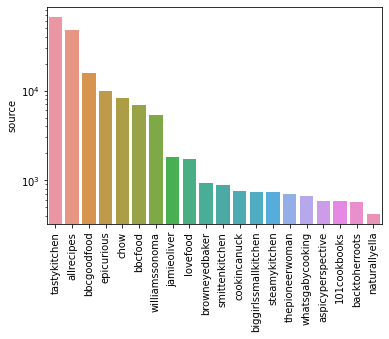

In [119]:
ax = sns.barplot(x = top20_sources.index, y = top20_sources)
                           
ax.set(yscale='log')
                           
for item in ax.get_xticklabels():
    item.set_rotation(90)

In [121]:
#We can assign a reputation score to the recipe based on the source

In [131]:
#let's add a reputation_score column to the recipes dataframe
sources_ranked_df = recipes.source.value_counts().reset_index()
sources_ranked_df.columns = ['source','count']
sources_ranked_df['rank'] = sources_ranked_df.index + 1

In [134]:
sources_ranked_df.head()

,source,count,rank
0,tastykitchen,66700,1
1,allrecipes,47086,2
2,bbcgoodfood,15550,3
3,epicurious,9787,4
4,chow,8312,5


In [135]:
recipes.head()

,_id,name,ingredients,url,image,ts,cookTime,source,recipeYield,datePublished,prepTime,description,totalTime,creator,recipeCategory,dateModified,recipeInstructions
0,{'$oid': '5160756b96cc62079cc2db15'},Drop Biscuits and Sausage Gravy,Biscuits\n3 cups All-purpose Flour\n2 Tablespo...,http://thepioneerwoman.com/cooking/2013/03/dro...,http://static.thepioneerwoman.com/cooking/file...,{'$date': 1365276011104},PT30M,thepioneerwoman,12,2013-03-11,PT10M,"Late Saturday afternoon, after Marlboro Man ha...",NaN,NaN,NaN,NaN,NaN
1,{'$oid': '5160756d96cc62079cc2db16'},Hot Roast Beef Sandwiches,12 whole Dinner Rolls Or Small Sandwich Buns (...,http://thepioneerwoman.com/cooking/2013/03/hot...,http://static.thepioneerwoman.com/cooking/file...,{'$date': 1365276013902},PT20M,thepioneerwoman,12,2013-03-13,PT20M,"When I was growing up, I participated in my Ep...",NaN,NaN,NaN,NaN,NaN
2,{'$oid': '5160756f96cc6207a37ff777'},Morrocan Carrot and Chickpea Salad,Dressing:\n1 tablespoon cumin seeds\n1/3 cup /...,http://www.101cookbooks.com/archives/moroccan-...,http://www.101cookbooks.com/mt-static/images/f...,{'$date': 1365276015332},NaN,101cookbooks,NaN,2013-01-07,PT15M,A beauty of a carrot salad - tricked out with ...,NaN,NaN,NaN,NaN,NaN
3,{'$oid': '5160757096cc62079cc2db17'},Mixed Berry Shortcake,Biscuits\n3 cups All-purpose Flour\n2 Tablespo...,http://thepioneerwoman.com/cooking/2013/03/mix...,http://static.thepioneerwoman.com/cooking/file...,{'$date': 1365276016700},PT15M,thepioneerwoman,8,2013-03-18,PT15M,It's Monday! It's a brand new week! The birds ...,NaN,NaN,NaN,NaN,NaN
4,{'$oid': '5160757496cc6207a37ff778'},Pomegranate Yogurt Bowl,For each bowl: \na big dollop of Greek yogurt\...,http://www.101cookbooks.com/archives/pomegrana...,http://www.101cookbooks.com/mt-static/images/f...,{'$date': 1365276020318},NaN,101cookbooks,Serves 1.,2013-01-20,PT5M,A simple breakfast bowl made with Greek yogurt...,NaN,NaN,NaN,NaN,NaN


In [140]:
ranked_recipes = pd.merge(left=recipes, right=sources_ranked_df)

In [151]:
ranked_selection = ranked_recipes.iloc[selection.index].sort_values(by=['rank']).name

In [152]:
print(ranked_selection)

93768                          Cheddar-Garlic Skillet Bread
113926              Fresh Gnocchi with Mushroom Cream Sauce
137686                         Steak with Parisienne Butter
140530                               Healthy Funfetti Shake
158475                   Crab, avocado &amp; lime cocktails
158486                      Crab cakes with dill mayonnaise
74964                                  Brook Trout Müllerin
165243     Banana puddings with salted caramel sauce recipe
2069        Tunisian-Style Poached Eggs in Red Pepper Sauce
163175    Honey Balsamic Strawberries with Whipped Vanil...
Name: name, dtype: object


<!--NAVIGATION-->
< [Pivot Tables](03.09-Pivot-Tables.ipynb) | [Contents](Index.ipynb) | [Working with Time Series](03.11-Working-with-Time-Series.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.10-Working-With-Strings.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
